In [ ]:
import torch
import torchvision
import numpy as np
import os

dps = 5
n_sequences = 10000
output_path = './dataset'

emnist_dataset = torchvision.datasets.EMNIST('./EMNIST', split='digits', train=True, download=True)
dataset_sequences = []
dataset_label = []

100%|██████████| 562M/562M [00:02<00:00, 221MB/s]


In [ ]:
emnist_dataset.data.shape

torch.Size([240000, 28, 28])

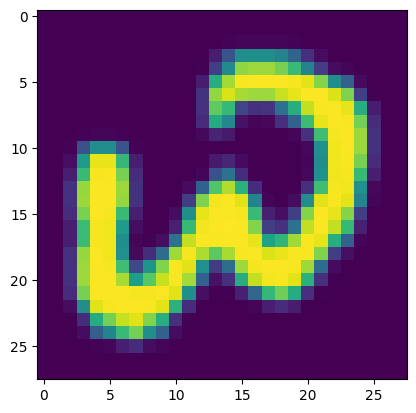

In [ ]:
import matplotlib.pyplot as plt
import random
i = random.randint(0, len(emnist_dataset.data))
plt.imshow( emnist_dataset.data[i])

#Images need to undergo transformation as 90 degree anticlockwise rotation and  

In [ ]:
for i in range(n_sequences):
  random_indices = np.random.randint(len(emnist_dataset.data), size=(dps,) )
  random_digits_data = emnist_dataset.data[random_indices]
  transformed_random_digits_images= []
  for img in random_digits_data:
    temp = torchvision.transforms.ToPILImage()(img)
    temp = torchvision.transforms.functional.rotate(temp, -90, fill=(0,))
    temp = torchvision.transforms.functional.hflip(temp)
    # random tilting of images
    temp = torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.2), scale=(0.8,1.))(temp)
    temp = torchvision.transforms.ToTensor()(temp).numpy()
    transformed_random_digits_images.append(temp)

  random_digit_images = np.array(transformed_random_digits_images)
  random_digit_label = emnist_dataset.targets[random_indices]

  random_sequence = np.hstack(random_digit_images.reshape(dps, 28, 28))
  random_label = np.hstack(random_digit_label.reshape(dps, 1))

  dataset_sequences.append(random_sequence / 255)
  dataset_label.append(random_label)


In [ ]:
if not os.path.exists(output_path):
  os.makedirs(output_path)

dataset_data = np.array(dataset_sequences)
dataset_label = np.array(dataset_label)
np.save(os.path.join(output_path, 'sequence.npy'), dataset_sequences)
np.save(os.path.join(output_path, 'label.npy'), dataset_label)

In [ ]:
from torch.utils.data import TensorDataset
import numpy as np
data_path = output_path + "/sequence.npy"
label_path = output_path + "/label.npy"

data = np.load(data_path)
label = np.load(label_path)
data  = torch.Tensor(data)
label= torch.IntTensor(label)
sequence_dataset = TensorDataset(data, label)
train_set, test_set = torch.utils.data.random_split(sequence_dataset, [int(len(label)*0.8), int(len(label)*0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

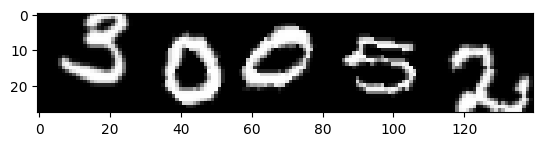

In [ ]:
for x_, y_ in train_loader:
  for j in range(len(x_)):
    plt.imshow(x_[j], cmap='grey')
    plt.show()

    break
  break

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.num_classes = 10 + 1
        self.image_H = 28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        self.in1 = nn.InstanceNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3))
        self.in2 = nn.InstanceNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2)
        self.in3 = nn.InstanceNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.in4 = nn.InstanceNorm2d(64)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.in5 = nn.InstanceNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        self.in6 = nn.InstanceNorm2d(64)

        self.postconv_height= 3
        self.postconv_width= 31

        self.gru_input_size = self.postconv_height*64
        self.gru_hidden_size = 128
        self.gru_num_layers = 2
        self.gru_h = None
        self.gru_cell = None
        self.gru  = nn.GRU(self.gru_input_size, self.gru_hidden_size, self.gru_num_layers, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(self.gru_hidden_size*2, self.num_classes)
    def forward(self,x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = F.leaky_relu(out)
        out = self.in1(out)

        out = self.conv2(out)
        out = F.leaky_relu(out)
        out = self.in2(out)

        out = self.conv3(out)
        out = F.leaky_relu(out)
        out = self.in3(out)

        out = self.conv4(out)
        out = F.leaky_relu(out)
        out = self.in4(out)

        out = self.conv5(out)
        out = F.leaky_relu(out)
        out = self.in5(out)

        out = self.conv6(out)
        out = F.leaky_relu(out)
        out = self.in6(out)

        out = out.permute(0, 3, 2, 1)

        out = out.reshape(batch_size, -1, self.gru_input_size)
        self.gru_h = self.gru_h.to(device)
        out, self.gru_h = self.gru(out, self.gru_h)
        self.gru_h = self.gru_h.detach()

        out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
        return out
    def reset_hidden(self, batch_size):
        h = torch.zeros(self.gru_num_layers*2, batch_size, self.gru_hidden_size)
        self.gru_h = Variable(h)
        self.gru_h.to(device)

crnn = CRNN().to(device)
criterion = nn.CTCLoss(blank=10, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(crnn.parameters(), lr=0.001)

BLANK_LABEL = 10
EPOCHS = 100

In [ ]:
from itertools import groupby

def train():
    correct = 0
    total = 0

    total_loss = 0
    num_batches = 0

    for batch_idx, (x_train , y_train)  in enumerate(train_loader):
        batch_size = x_train.shape[0]
        crnn.reset_hidden(batch_size)
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])

        optimizer.zero_grad()

        y_pred = crnn(x_train)
        y_pred = y_pred.permute(1,0,2)

        input_lengths= torch.IntTensor(batch_size).fill_(crnn.postconv_width)
        target_lengths = torch.IntTensor([len(b) for b in y_train])

        loss = criterion(y_pred,y_train, input_lengths, target_lengths)

        total_loss += loss.cpu()

        loss.backward()
        optimizer.step()

        _, max_index = torch.max(y_pred, 2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:,i])

            prediction = torch.IntTensor([c for c , _ in groupby(raw_prediction)  if c!=BLANK_LABEL]).to(device)
            if (len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i]))):
                correct += 1
            total += 1

        num_batches += 1
    ratio = correct/total
    print("Train correct: ", correct, "total: ", total, "ratio: ", ratio)
    return total_loss/num_batches, ratio

In [ ]:
for e in range(EPOCHS):
    training_loss = train()

    if e == 5:
        print(f"Training Loss {training_loss}")


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  488 total:  8000 ratio:  0.061


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  5568 total:  8000 ratio:  0.696


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  6726 total:  8000 ratio:  0.84075


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7052 total:  8000 ratio:  0.8815


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7329 total:  8000 ratio:  0.916125


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7480 total:  8000 ratio:  0.935
Training Loss (tensor(0.0481, grad_fn=<DivBackward0>), 0.935)


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7636 total:  8000 ratio:  0.9545


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7792 total:  8000 ratio:  0.974


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7648 total:  8000 ratio:  0.956


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7766 total:  8000 ratio:  0.97075


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7780 total:  8000 ratio:  0.9725


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7887 total:  8000 ratio:  0.985875


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7701 total:  8000 ratio:  0.962625


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7849 total:  8000 ratio:  0.981125


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipy

Train correct:  7951 total:  8000 ratio:  0.993875


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])


KeyboardInterrupt: 

In [ ]:
for x, y in train_loader:
    batch_size = x.shape[0]
    crnn.reset_hidden(batch_size)
    x_train = x.to(device)
    y_train = y.to(device)
    x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
    y_pred = crnn(x_train)
    y_pred = y_pred.permute(1,0,2)
    print(y_pred.shape)
    print(y.shape)
    break

torch.Size([31, 64, 11])
torch.Size([64, 5])


/tmp/ipython-input-30-3391753102.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.stack([F.log_softmax(self.fc(out[i])) for i in range(out.shape[0])])
